<a href="https://colab.research.google.com/github/yasuhiroinoue/AppMathSci/blob/main/%E5%BF%9C%E7%94%A8%E6%95%B0%E7%90%86(12_13).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**応用数理科学（第10回）**##
観測データから、数理モデルのパラメータをベイズ推定する方法を学ぶ。

##**Approximated Bayesian Computation (ABC) with Sequential Monte Carlo (SMC)**##

簡単に言えば、モデルのパラメータベクトル$\theta$を事前分布からサンプリングし、サンプリングされたパラメータのもと、シミュレーションによってデータ$x$を生成し、実験データ$x_0$と近ければ($d(x,x_0)\leq ϵ$)、サンプリングした$\theta$値を採択する、ということを繰り返す(ABC)。ABCでの閾値$ϵ$を仮想時間の経過とともに徐々に小さくしながら計算(SMC)することで、事後確率$\pi(\theta|d(x,x_0)\leq ϵ)$を推定する。計算機の力で押し切る。

**解説**

**Approximated Bayesian Computation (ABC)**

$\theta$を推定したいパラメータベクトルとする。事前確率$\pi (\theta)$、データ$x$が与えられたときの$\theta$の尤度関数$f(x|\theta)$として、事後確率は
$$
\pi(\theta|x) \propto f(x|\theta)\pi(\theta)
$$
である。尤度関数$f(x|\theta)$の計算が困難な時に、この事後確率を近似計算する方法が、ABCである。


1.   提案分布$\pi(\theta)$からパラメータベクトル$\theta^*$をサンプリングする
2.   $\theta^*$を用いてシミュレーションを動かし、データ$x^*$を得る。
3.   シミュレーションデータ$x^*$と実験データ$x_0$から、距離$d(x_0,x^*)$を計算し、$d(x_0,x^*) \leq \epsilon$であれば、$\theta^*$を採用する。1に戻る。

この手続きで、$\pi(\theta|d(x_0,x^*)\leq \epsilon)$が得られる。$ϵ$が十分に小さければ、事後確率の良い近似となる。

ただし、この方法には、事前確率が事後確率と大きく異なっているときに、採択率が低くなる欠点がある（事後確率の近似分布を得るまでに非常に長い計算時間がかかる）。

そこで、Monte Carlo法と組み合わせた方法がいくつか提案されており、本講義ではABC-SMCを簡単に紹介する。


**ABC-SMC**

事前確率から、複数のパラメータベクトル値 (粒子と呼ぶ)$\{\theta^{(1)},...,\theta^{(N)}\}$をサンプリングする。
閾値$ϵ$について、$ϵ_1 > \cdots > ϵ_T \geq 0$として、サンプリング初期では、大きめの$ϵ$値を使い採択率を上げることで、パラメータ値の更新が簡単に生じるようにし、次第に小さな値にしていき、事後分布を収束させる。

つまり、事前分布$\pi(\theta)$から中間の提案分布$\pi(\theta|d(x_0,x*)\leq ϵ_t)$を経由し、最終的に事後分布$\pi(\theta|d(x_0,x*)\leq ϵ_T)$から粒子をサンプリングしているとみなせるまで計算を行う。

$\theta$の初期分布$\pi(\theta)$、 $ϵ_1 > \cdots > ϵ_T$、粒子$\{\theta_t^{(i)}\}$ $(i=1,...,N; t=0,...,T)$として、次のアルゴリズムを繰り返す。

1.   $t=0$のとき、$\theta^{**}$を$\pi(\theta)$からサンプリングする<br>$t>0$のとき、まず、前の粒子$\{\theta_{t-1}^{(i)}\}$から重み$w_{t-1}$をもとに、$\theta^*$をサンプリングし、次に、$\theta^{**}$を摂動カーネル$K_t(\theta|\theta^*)$からサンプリングする。これは、提案分布$\pi_t(\theta) = \frac{1}{N}\sum_{i=1}^Nw_{t-1}^{(i)}K_t(\theta|\theta_{t-1}^{(i)})$からのサンプリングと等価である。
もし、$\pi(\theta^{**})=0$であれば、1の最初に戻る。
2.   シミュレーションデータ$x^*$を発生させる。$x^* \sim f(x|\theta^{**})$<br>もし、$d(x^*,x_0)\geq ϵ_t$なら、1の最初に戻る。
3.   $\theta_t^{(i)}=\theta^{**}$とし、$\theta_t^{(i)}$の重みを計算する<br>$$
w_t^{(i)}=\left\{\begin{matrix}
1 & (t=0)\\
\frac{\pi(\theta_t^{(i)})}{\sum_{j=1}^N w_{t-1}^{(j)}K_t(\theta_{t-1}^{(j)},\theta_t^{(i)})} & (t > 0)
\end{matrix}\right.
$$
粒子サンプルについて、$\theta^*$は前の分布から、$\theta^{**}$は摂動後の分布からを表す。$K_t$はランダムウォークになるよう、一様分布かガウス分布が用いられる。

Refs.<br>
https://royalsocietypublishing.org/doi/abs/10.1098/rsif.2008.0172 <br>
https://academic.oup.com/sysbio/article/66/1/e66/2420817 <br>
https://link.springer.com/article/10.1007/s11222-011-9271-y


##**ロトカ・ボルテラ方程式**##


In [ ]:
#PyMC v5.12.0　(注意：v5.13.0 -- 5.17.0では、ABCは動かない(Colab上での確認）)
!pip install watermark
!pip install pymc==5.12.0


In [20]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

%load_ext watermark
az.style.use("arviz-darkgrid")

Running on PyMC v5.12.0
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [21]:
from scipy.integrate import odeint

# ロトカ・ボルテラ方程式

# Definition of parameters
a = 1.0
b = 0.1
c = 1.5
d = 0.75

# initial population of rabbits and foxes
X0 = [10.0, 5.0]
# size of data
size = 100
# time lapse
time = 15
t = np.linspace(0, time, size)

# Lotka - Volterra equation
def dX_dt(X, t, a, b, c, d):
    """ Return the growth rate of fox and rabbit populations. """

    return np.array([a * X[0] - b * X[0] * X[1], -c * X[1] + d * b * X[0] * X[1]])


# simulator function
def competition_model(rng, a, b, c, d, size=None):
    return odeint(dX_dt, y0=X0, t=t, rtol=0.01, args=(a, b, c, d))

In [22]:
# function for generating noisy data to be used as observed data.
def add_noise(a, b, c, d):
    noise = np.random.normal(size=(size, 2))
    simulated = competition_model(None, a, b, c, d) + noise
    return simulated

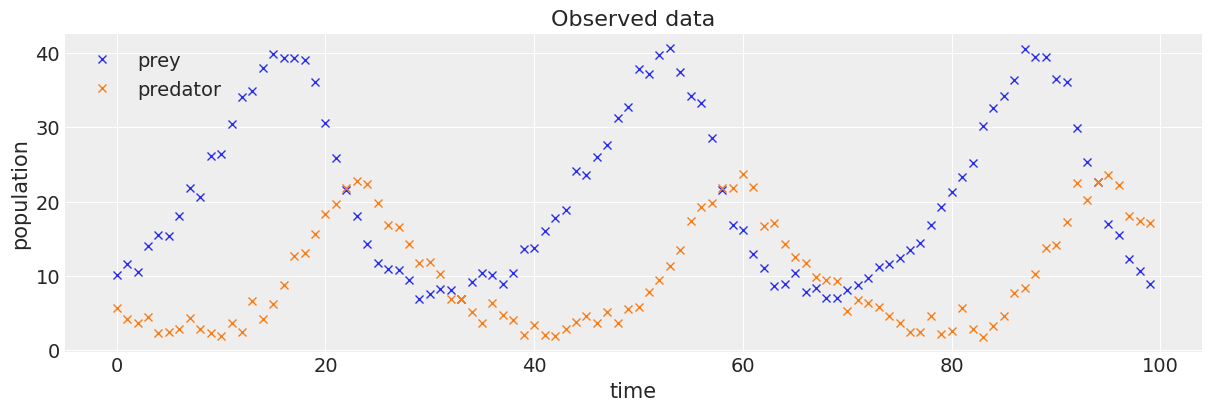

In [23]:
# plotting observed data.
observed = add_noise(a, b, c, d)
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(observed[:, 0], "x", label="prey")
ax.plot(observed[:, 1], "x", label="predator")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Observed data")
ax.legend();

In [24]:
with pm.Model() as model_lv:
    a = pm.HalfNormal("a", 1.0) ##非負値
    b = pm.HalfNormal("b", 1.0) ##非負値
    c = pm.HalfNormal("c", 1.0) ##非負値
    d = pm.HalfNormal("d", 1.0) ##非負値

    sim = pm.Simulator("sim", competition_model, params=(a, b, c, d), epsilon=10, observed=observed)

    idata_lv = pm.sample_smc()

/usr/local/lib/python3.10/dist-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
<ipython-input-21-1aa4626a3f98>:28: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get 

<ipython-input-21-1aa4626a3f98>:28: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(dX_dt, y0=X0, t=t, rtol=0.01, args=(a, b, c, d))


Refs. PyMC<br>
https://docs.pymc.io/en/latest/api/distributions/simulator.html<br>
https://docs.pymc.io/en/latest/api/smc/sample_smc.html?highlight=smc_sampler

array([[<Axes: title={'center': 'a'}>,
        <Axes: title={'center': 'a'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'b'}>,
        <Axes: title={'center': 'b'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'c'}>,
        <Axes: title={'center': 'c'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'd'}>,
        <Axes: title={'center': 'd'}, xlabel='Rank (all chains)'>]],
      dtype=object)

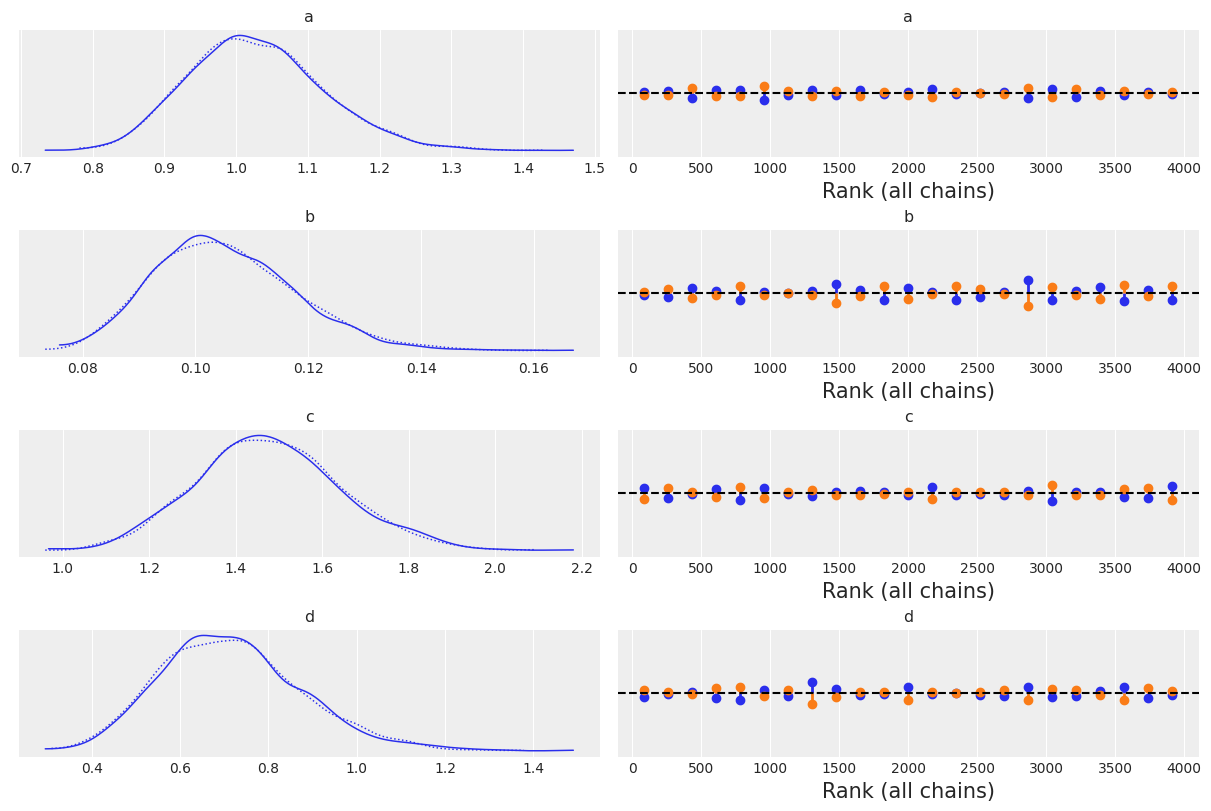

In [25]:
##２つのchainで互いに事後分布が一致している
##Rank
az.plot_trace(idata_lv, kind="rank_vlines")

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'c'}>, <Axes: title={'center': 'd'}>],
      dtype=object)

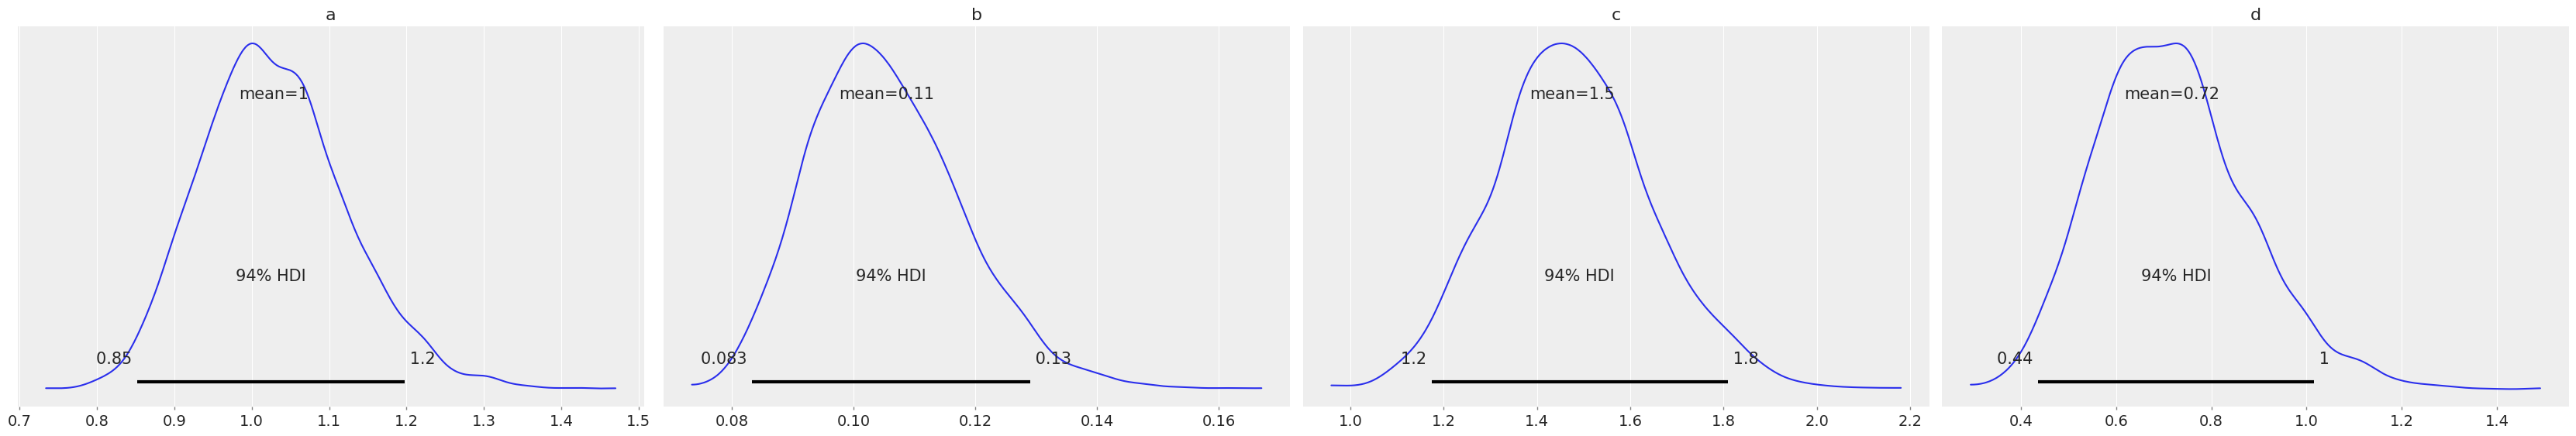

In [26]:
## Highest density interval (HDI) 区間HDIにある点は、区間外の点よりも必ず確率密度が高い
az.plot_posterior(idata_lv)

In [27]:
az.summary(idata_lv)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.028,0.095,0.852,1.198,0.002,0.001,3918.0,3732.0,1.0
b,0.105,0.013,0.083,0.129,0.000,0.000,3848.0,3474.0,1.0
c,1.476,0.168,1.174,1.809,0.003,0.002,3975.0,3571.0,1.0
d,0.716,0.160,0.435,1.016,0.003,0.002,3877.0,3718.0,1.0


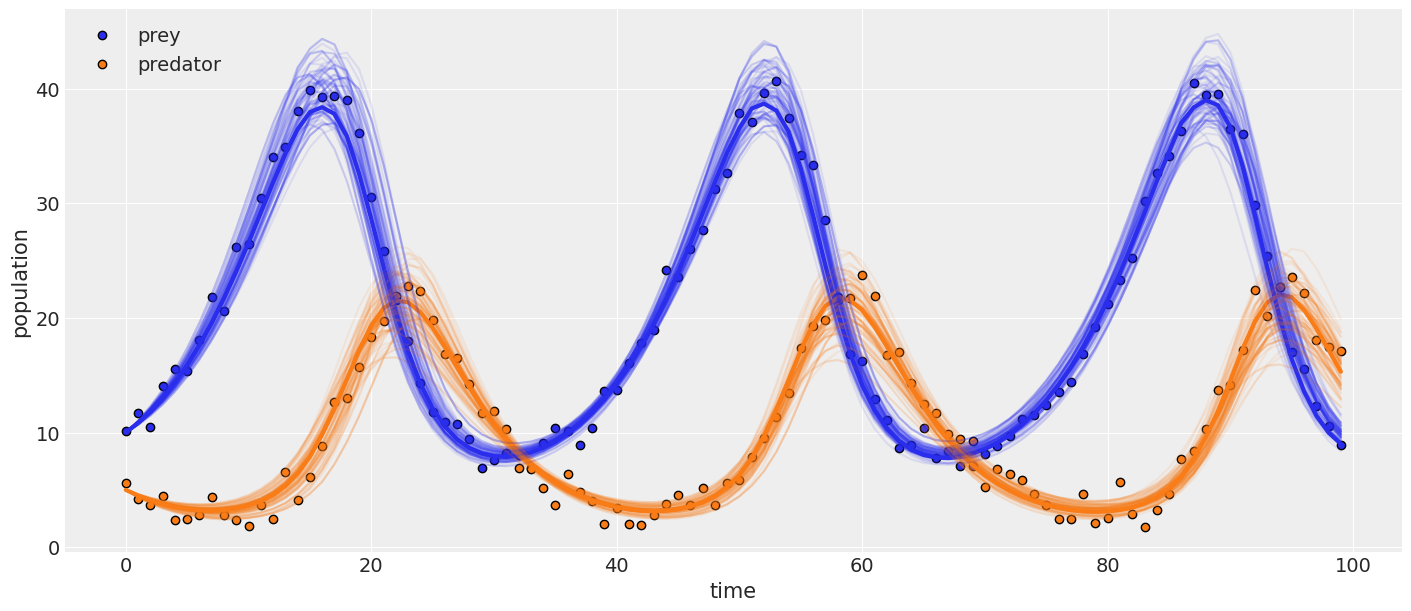

In [28]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
posterior = idata_lv.posterior.stack(samples=("draw", "chain"))
a_trace = posterior["a"]
b_trace = posterior["b"]
c_trace = posterior["c"]
d_trace = posterior["d"]

ax.plot(observed[:, 0], "o", label="prey", c="C0", mec="k")
ax.plot(observed[:, 1], "o", label="predator", c="C1", mec="k")
ax.plot(competition_model(None, a_trace.mean().item(), b_trace.mean().item(), c_trace.mean().item(), d_trace.mean().item()), linewidth=3)
for i in np.random.randint(0, size, 100):
    sim = competition_model(None, a_trace[i].item(), b_trace[i].item(), c_trace[i].item(), d_trace[i].item())
    ax.plot(sim[:, 0], alpha=0.1, c="C0")
    ax.plot(sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();

自分用メモ==>上記まで、バージョンアップ完了(2024.10.08)

##**隠れ系の推定**##

第1回講義では、人口動態について、環境収容力を仮定したモデルを導入し、人口飽和へ漸近することを説明した。
しかしながら、日本において、2010年頃以降は人口減少に転じており、一定値への漸近とは異なる傾向を示しているとも考えられる。
そこで、環境収容力の時間変化をモデル化し、人口動態の説明の再考を試みる。

もちろん、環境収容力などというものは測定することはできないので、これは観測から完全に隠れているとみなす。隠れ系（環境収容力）の動態を、観測できる量（人口データ）のみから推定し、観測量を説明する、というのが演習の主旨である。


講義用の演習データは下記からダウンロードできる。<br>
https://www.dropbox.com/scl/fi/1a4g2x43adtplno0ydb5c/population.csv?rlkey=qqsc0kpf8tg1hd66l7h4ff6w7&dl=0

また、Googleで「日本 人口」と検索すれば、Data Commonsから最新データを取得できるので、そちらを使っても良い。

環境収容力$N_\infty$は定数ではなく、各年$t$の関数$N_\infty(t)$であるとする。その時間変化の方程式として
$$
\frac{dN_\infty}{dt}=aN\left(1-q-\frac{N}{N_\infty} \right)
$$
とする($a \geq 0$)。
このもとで、第1回講義で紹介した人口動態モデルをABC-SMCで実データに当てはめる。$a=0$のとき、第1回講義と同じ方程式となる。
$$
\frac{dN}{dt} = \gamma N \left(1 - \frac{N}{N_\infty} \right)
$$

In [ ]:
import numpy as np #numpy
from scipy.integrate import odeint #odeint
import matplotlib.pyplot as plt #to draw graphs
import pandas as pd

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [ ]:
##1960-70年は傾向が異なるように見えるので、今回は除外する
df_o = pd.read_csv("population.csv",sep=",")
df = df_o.drop(range(10))

In [ ]:
data_x = df["year"].values
data_y = df["population"].values

In [ ]:
t = np.linspace(0,51,52)
def func(y,t,g,q,a):
  n,no=y
  dndt = [g*n*(1-n/no), a*n*(1-q - n/no) ]
  return dndt

In [ ]:
# simulator function
def pop_model(g,q,a):
    b=1.35
    n0 = [data_y[0],b*1e+8]
    sol = odeint(func, n0, t, rtol=0.01,args=(g,q,a))
    pop = sol[:,0]
    return pop

In [ ]:
def disp_pop(g,q,a):
    b=1.35
    n0 = [data_y[0],b*1e+8]
    sol = odeint(func, n0, t, rtol=0.01,args=(g,q,a))
    return sol

In [ ]:
with pm.Model() as model_pop:
    g = pm.HalfNormal("g", 0.2) ##非負値
    q = pm.HalfNormal("q", 0.2) ##非負値
    a = pm.HalfNormal("a", 0.1) ##非負値
   # b = pm.HalfNormal("b", 1.0) ##非負値

    sim = pm.Simulator("sim", pop_model, params=(g,q,a), epsilon=0.02e+8, observed=data_y)

    trace_pop = pm.sample_smc(kernel="ABC", parallel=True)
    idata_pop = az.from_pymc3(trace_pop)

/usr/local/lib/python3.10/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/p

array([[<Axes: title={'center': 'g'}>,
        <Axes: title={'center': 'g'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'q'}>,
        <Axes: title={'center': 'q'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'a'}>,
        <Axes: title={'center': 'a'}, xlabel='Rank (all chains)'>]],
      dtype=object)

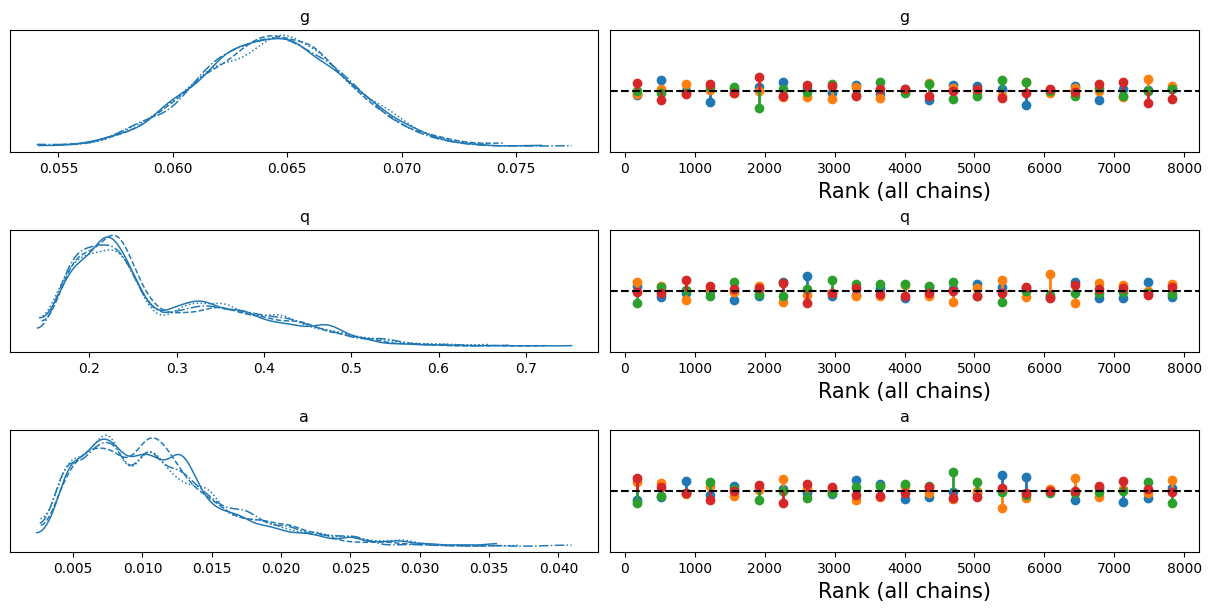

In [ ]:
az.plot_trace(idata_pop, kind="rank_vlines")

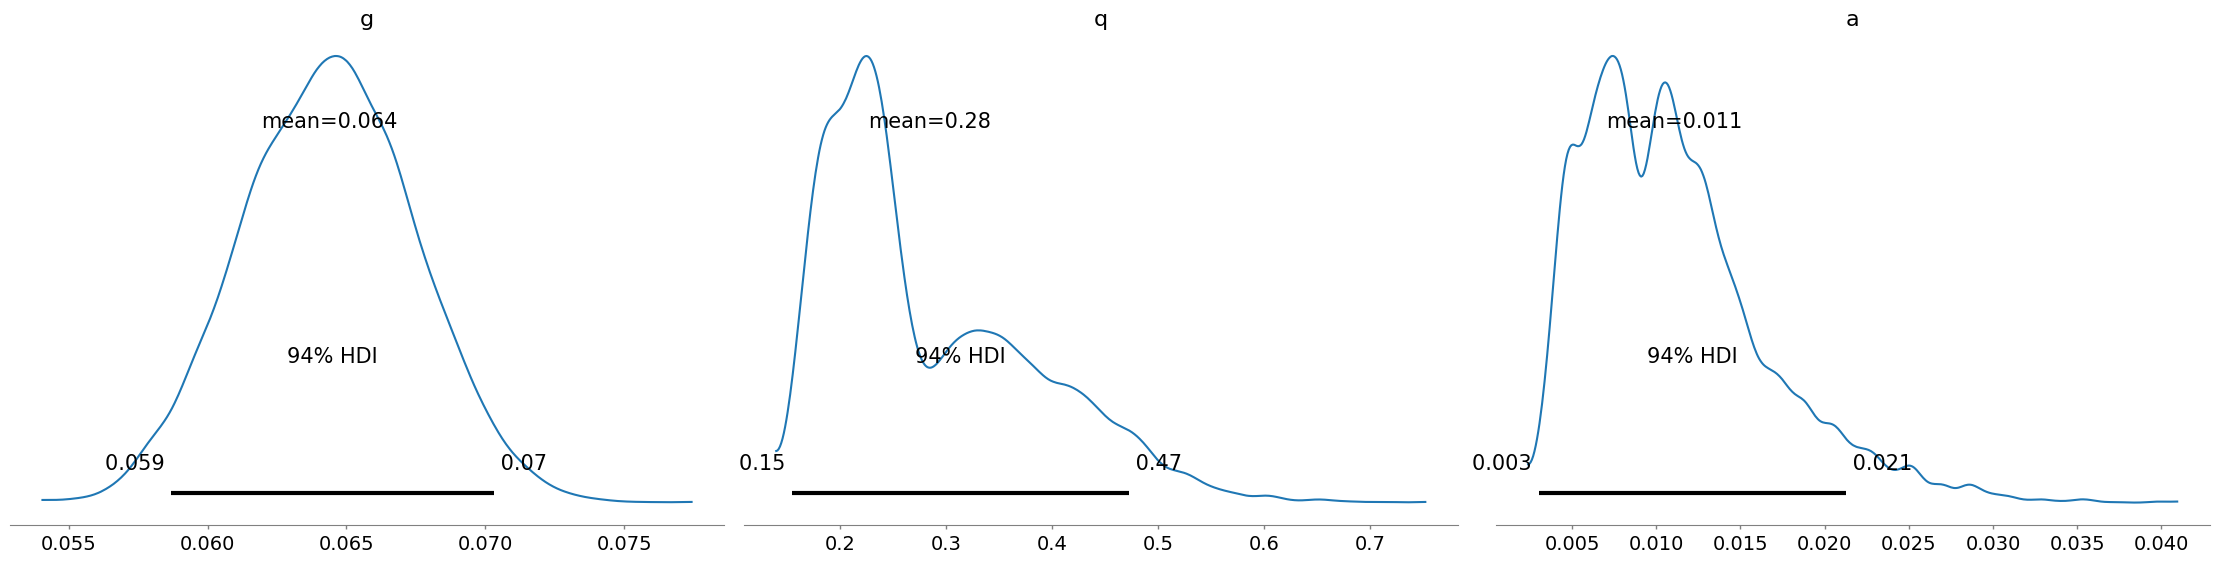

In [ ]:
## Highest density interval (HDI) 区間HDIにある点は、区間外の点よりも必ず確率密度が高い
az.plot_posterior(idata_pop);

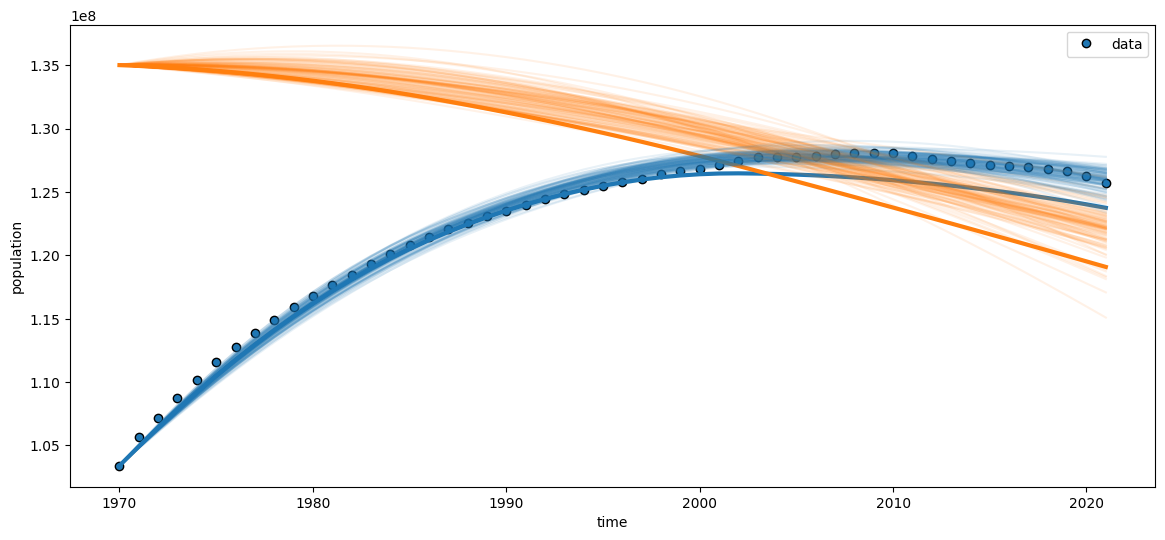

In [ ]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_x,data_y, "o", label="data", c="C0", mec="k")
ax.plot(data_x,disp_pop(trace_pop["g"].mean(),  trace_pop["q"].mean(),  trace_pop["a"].mean()), linewidth=3)
for i in np.random.randint(0, len(trace_pop), 100):
    sim = disp_pop(trace_pop["g"][i], trace_pop["q"][i],  trace_pop["a"][i])
    ax.plot(data_x,sim[:,0], alpha=0.1, c="C0")
    ax.plot(data_x,sim[:,1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();

In [ ]:
print(trace_pop["g"].mean())
print(trace_pop["q"].mean())
print(trace_pop["a"].mean())

0.06437594585106808
0.28458040229791887
0.011069957057617203


##**非線形フィッティング**##

京都の月平均気温の時系列を次の関数形でフィッティングする。
$$
Temp(t) = A\sin(\omega t + \phi) + B_0 + B_1t
$$

$\omega$の値が既知であれば、上式は関数と係数の線形結合$(\sin\omega t, \cos\omega t, 1, t)(A_1,A_2, B_0, B_1)^T$として、最小二乗法により求めることが出来る。しかし、$\omega$も未定係数の場合には、非線形フィッティングを行う必要がある。ここでは、ABC-SMCを用いた例と、比較のため局所最適化を避けるBasin-Hopping法を用いた非線形最適化の例を紹介する。

講義用の演習データは下記からダウンロード<br>
https://www.dropbox.com/scl/fi/ea6uzkfvwkwhw9wa6p3r6/data.csv?rlkey=gtjmfpoytq4mi8k94nkoq3d28&dl=0


最新のデータは、気象庁から直接ダウンロードできるので、それで試しても良いです。<br>
https://www.data.jma.go.jp/gmd/risk/obsdl/index.php

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pandas as pd
import math

In [ ]:
df_o = pd.read_csv('Kyoto_data.csv',encoding='SHIFT-JIS', skiprows=[0,1,2,3,4], names=['ym','temperature','q','f'])

In [ ]:
df=df_o.drop(['q','f'],axis=1)

In [ ]:
df['order']=np.linspace(0,df['ym'].shape[0]-1,df['ym'].shape[0])

In [ ]:
df

,ym,temperature,order
0,1990/9,24.7,0.0
1,1990/10,17.9,1.0
2,1990/11,13.7,2.0
3,1990/12,7.7,3.0
4,1991/1,5.1,4.0
...,...,...,...
394,2023/7,29.1,394.0
395,2023/8,30.3,395.0
396,2023/9,27.7,396.0
397,2023/10,18.2,397.0


In [ ]:
data_x = df.order.values
data_y = df.temperature.values

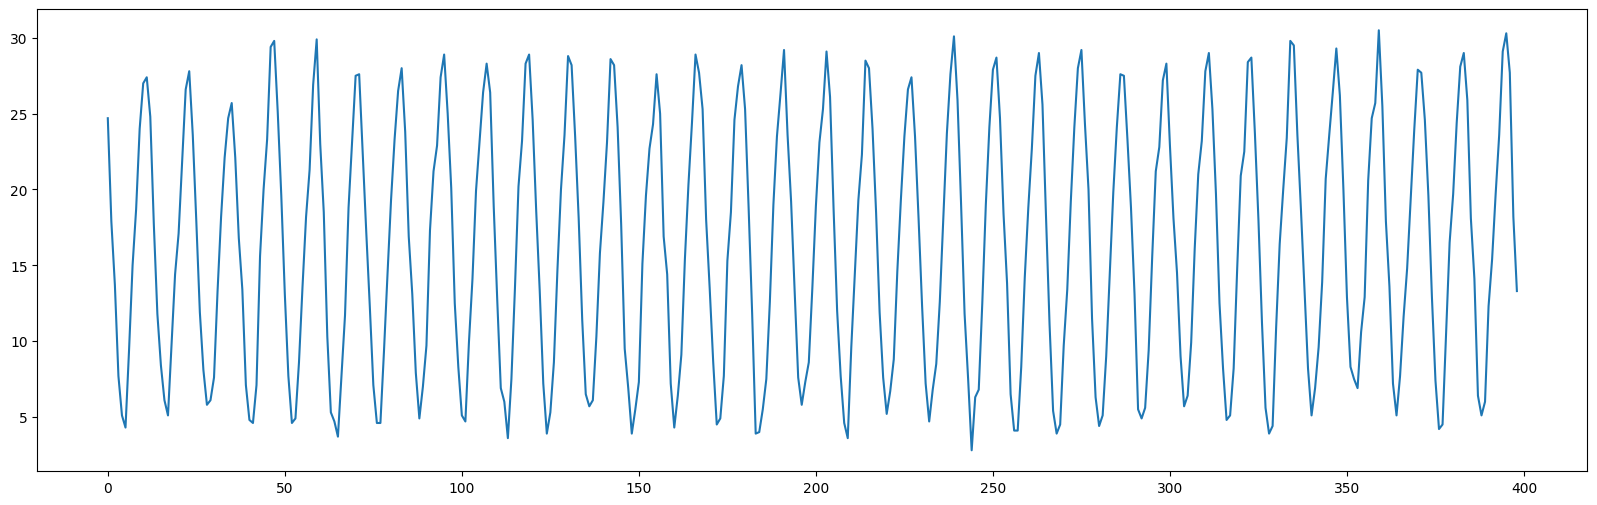

In [ ]:
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_y, label="data", c="C0", mec="k")

周期成分があるので、非線形フィッティングを行う必要がある。
まず、1次多項式による線形フィッティングを行い、直線成分と周期成分に分ける。

In [ ]:
from statsmodels.graphics.api import qqplot
import statsmodels.formula.api as smf
#先に最小二乗法で直線成分だけフィッティングし、あとで周期部分をSMCで決定する
## 1次
res1 = smf.ols('temperature ~ order', data=df).fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.032
Date:                Sun, 03 Dec 2023   Prob (F-statistic):              0.310
Time:                        13:09:31   Log-Likelihood:                -1408.0
No. Observations:                 399   AIC:                             2820.
Df Residuals:                     397   BIC:                             2828.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.5736      0.826     18.850      0.0

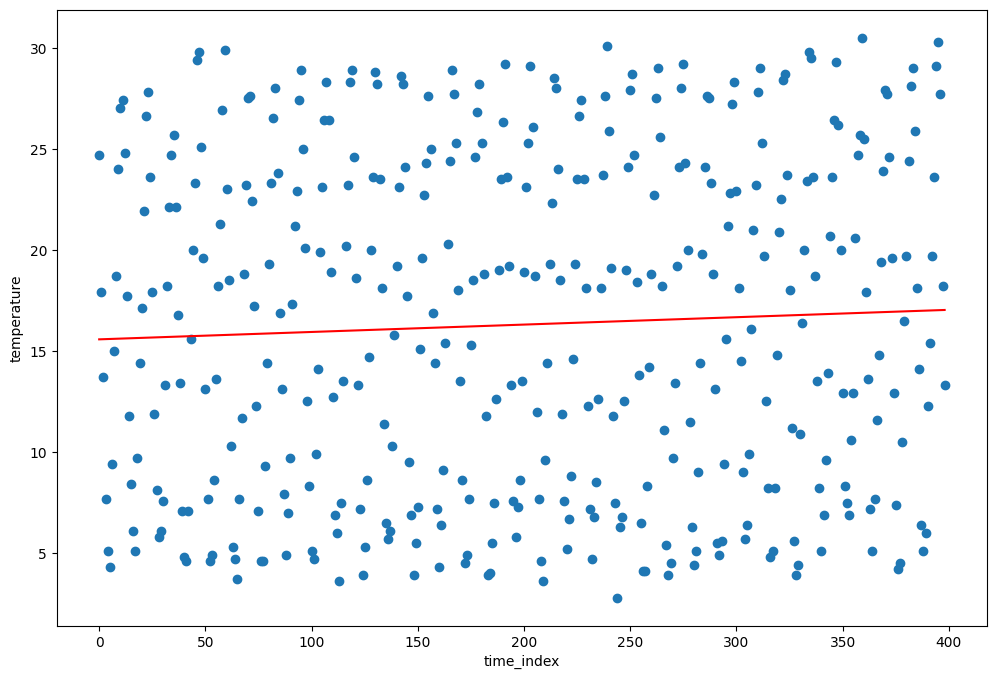

In [ ]:
b0, b1 = res1.params

fig = plt.figure(figsize=(12, 8))
plt.scatter(data_x, data_y)
plt.plot(data_x, b0 + b1*data_x, 'r')
plt.xlabel("time_index")
plt.ylabel("temperature")
plt.show()

In [ ]:
def siny(a,b,c):
  return a*np.sin(b*data_x + c)+b0+b1*data_x

with pm.Model() as model:
    a = pm.HalfNormal("a", 10) ##非負値
    b = pm.HalfNormal("b", 1) ##非負値
    c = pm.Uniform("c",lower=0, upper=2*math.pi)##範囲[0,2pi]

    sim = pm.Simulator("sim", siny, params=(a,b,c), epsilon=5, observed=data_y)

    trace = pm.sample_smc(kernel="ABC", parallel=True)
    idata = az.from_pymc3(trace)

array([[<Axes: title={'center': 'a'}>,
        <Axes: title={'center': 'a'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'b'}>,
        <Axes: title={'center': 'b'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'c'}>,
        <Axes: title={'center': 'c'}, xlabel='Rank (all chains)'>]],
      dtype=object)

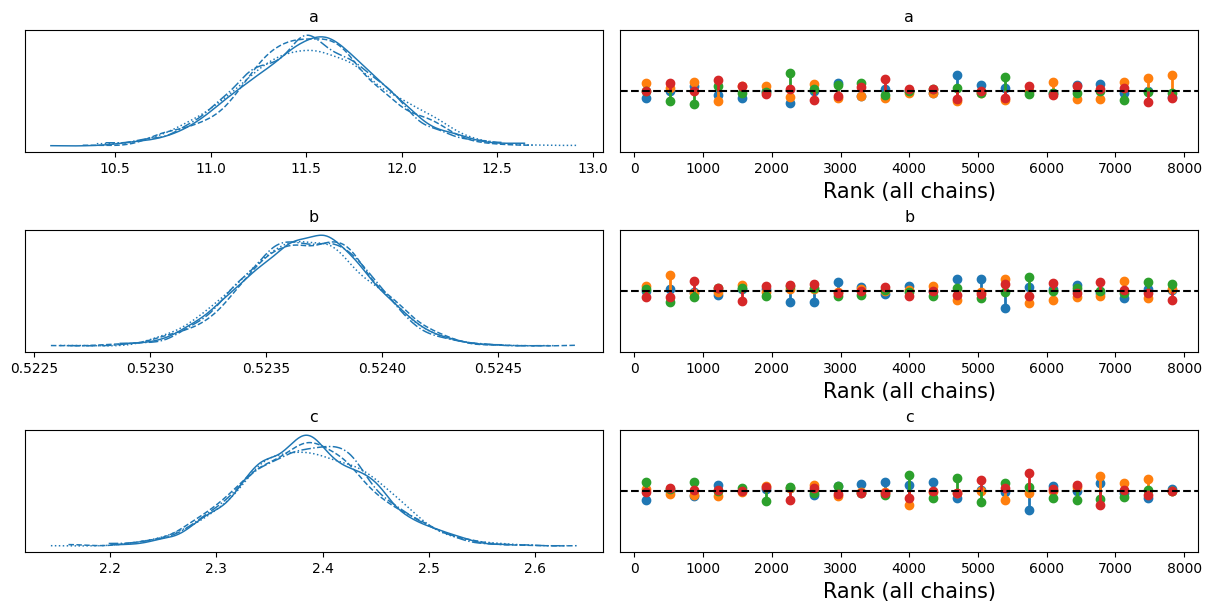

In [ ]:
#2つのchainで、事後確率分布は一致している
#colabのcpuでは、chain数は2になるが、もっと良いマシンを使えば、chain数を増やすことが出来る
az.plot_trace(idata, kind="rank_vlines")

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'c'}>], dtype=object)

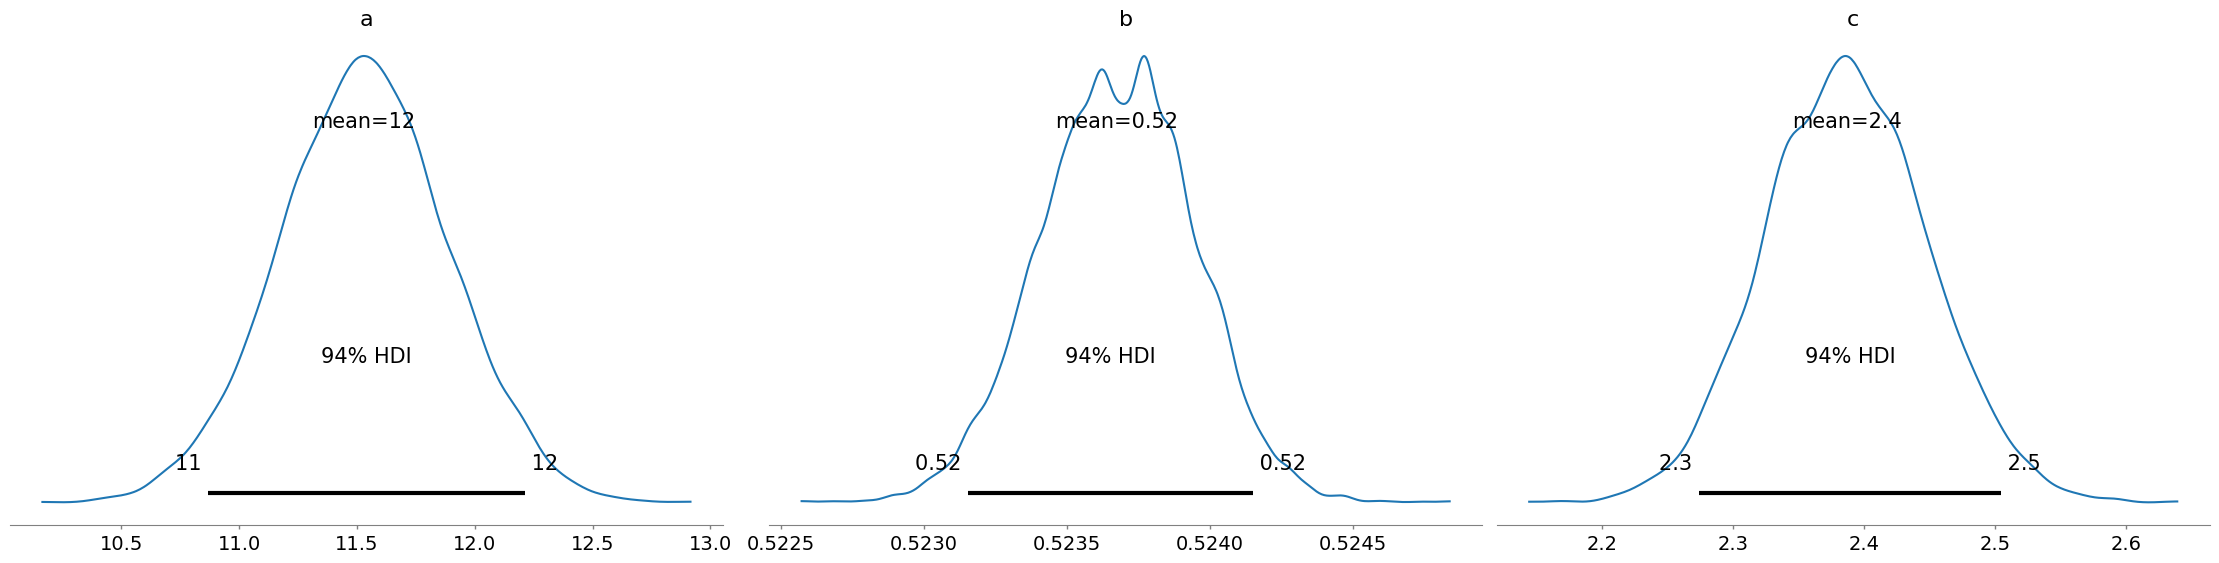

In [ ]:
## Highest density interval (HDI) 区間HDIにある点は、区間外の点よりも必ず確率密度が高い
az.plot_posterior(idata)

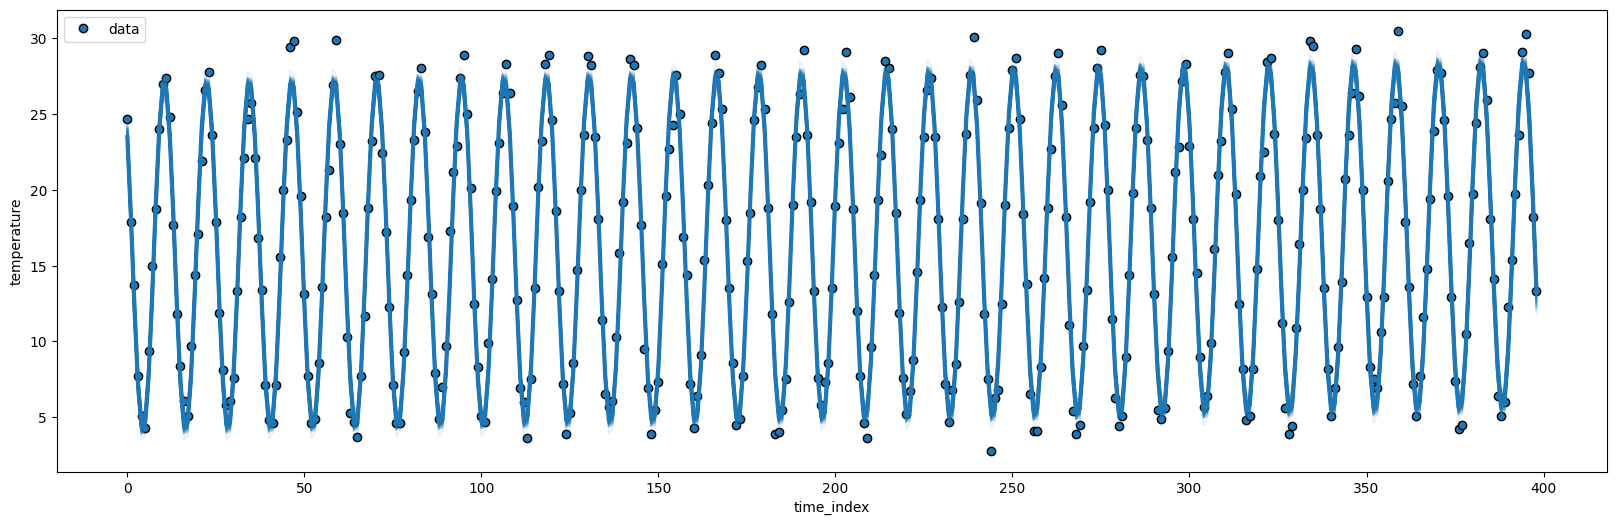

In [ ]:
# plot results
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_y, "o", label="data", c="C0", mec="k")
ax.plot(siny(trace["a"].mean(), trace["b"].mean(), trace["c"].mean()),linewidth=3)
for i in np.random.randint(0, len(trace), 100):
    sim = siny(trace["a"][i], trace["b"][i], trace["c"][i])
    ax.plot(sim, alpha=0.1, c="C0")
ax.set_xlabel("time_index")
ax.set_ylabel("temperature")
ax.legend();

In [ ]:
print("a",trace["a"].mean())
print("b",trace["b"].mean())
print("c",trace["c"].mean())
print("b0",b0)
print("b1",b1)

a 11.527902983131458
b 0.5236737406856515
c 2.3869409195475444
b0 15.573593984962406
b1 0.003650281482600952


###**非線形最適化法 Basin-hoppingとの比較**###

In [ ]:
from scipy.optimize import least_squares
from scipy.optimize import basinhopping

In [ ]:
def y(t,theta):
    return theta[0]*np.sin(theta[1]*t + theta[2])+theta[3]+theta[4]*t

In [ ]:
def calc_residuals(params, data_x, data_y):
    model_y = y(data_x, params)
    return model_y - data_y

In [ ]:
def calc_cost(params, data_x, data_y):
    residuals = calc_residuals(params, data_x, data_y)
    return (residuals * residuals).sum()

In [ ]:
a_init = [1,1,1,1,1]
minimizer_kwargs = {"args":(data_x, data_y)}
#basinhoppingはoptimize.minimize()を呼んでいるので、minimizerのdefaultはBFGS
res = basinhopping(calc_cost, a_init,stepsize=0.5,minimizer_kwargs=minimizer_kwargs,niter=200)

In [ ]:
res

                        fun: 613.9527439424501
 lowest_optimization_result:       fun: 613.9527439424501
 hess_inv: array([[ 2.71902467e-03, -5.47672947e-08, -4.28802557e-06,
        -9.33973953e-05,  5.96917785e-07],
       [-5.47672947e-08,  1.38815686e-09, -2.72697129e-07,
         8.98724674e-08, -4.53521721e-10],
       [-4.28802556e-06, -2.72697129e-07,  7.34266262e-05,
        -1.68336246e-05,  6.84174869e-08],
       [-9.33973954e-05,  8.98724674e-08, -1.68336246e-05,
         5.01300624e-03, -1.89316078e-05],
       [ 5.96917785e-07, -4.53521721e-10,  6.84174869e-08,
        -1.89316078e-05,  9.52612442e-08]])
      jac: array([-2.38037109e-03, -2.72298431e+00, -4.92401123e-02, -2.28118896e-03,
       -4.10980225e-01])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 263
      nit: 9
     njev: 42
   status: 2
  success: False
        x: array([-1.15572130e+01, -5.23667503e-01,  3.53107054e+01,  1.57823123e+01,
        2.51508793e-03])
    

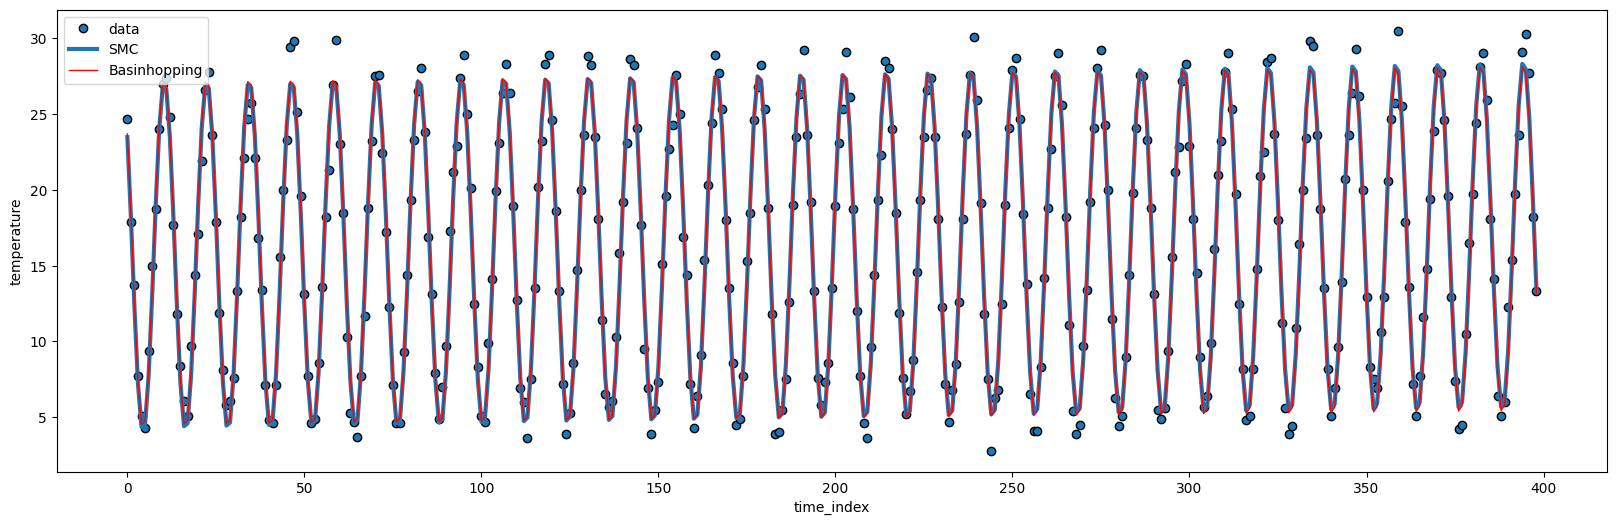

In [ ]:
a_fit = res.x
ys_fit = y(data_x,a_fit)

# plot results
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_y, "o", label="data", c="C0", mec="k")
ax.plot(siny(trace["a"].mean(), trace["b"].mean(), trace["c"].mean()), label="SMC", linewidth=3)
ax.plot(ys_fit,label="Basinhopping", c="red",linewidth=1)

ax.set_xlabel("time_index")
ax.set_ylabel("temperature")
ax.legend();

In [ ]:
res.x

array([-1.15572130e+01, -5.23667503e-01,  3.53107054e+01,  1.57823123e+01,
        2.51508793e-03])

In [ ]:
#AICの計算
def aic(n,x,sigma2):
  k=x.shape[0]#モデル自由度
  k+=1#分散も推定値になるので自由度1を足しておく
  return n*math.log(sigma2)+2*k + n + n*math.log(2.*math.pi)

n=len(data_x)
sigma2=res.lowest_optimization_result.fun/n

AIC=aic(n,res.x,sigma2)
print("AIC=",AIC)

AIC= 1316.2646105662034
